In [3]:
# importowanie bibliotek
import pandas as pd

                    patient ID
0             Malignant/Benign
1                radius (mean)
2               texture (mean)
3             perimeter (mean)
4                  area (mean)
5            smoothness (mean)
6           compactness (mean)
7             concavity (mean)
8        concave points (mean)
9              symmetry (mean)
10    fractal dimension (mean)
11             radius (stderr)
12            texture (stderr)
13          perimeter (stderr)
14               area (stderr)
15         smoothness (stderr)
16        compactness (stderr)
17          concavity (stderr)
18     concave points (stderr)
19           symmetry (stderr)
20  fractal dimension (stderr)
21              radius (worst)
22             texture (worst)
23           perimeter (worst)
24                area (worst)
25          smoothness (worst)
26         compactness (worst)
27           concavity (worst)
28      concave points (worst)
29            symmetry (worst)
30   fractal dimension (worst)
       8

StopIteration: 

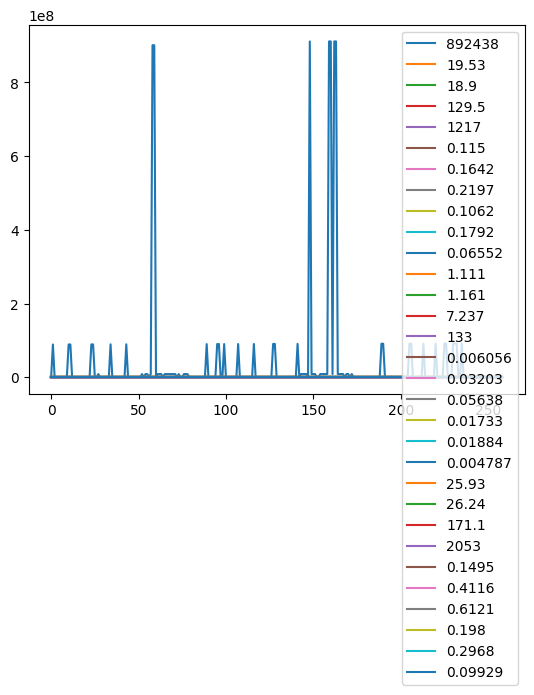

In [ ]:
breast_train = pd.io.parsers.read_csv("dataset\\breast-cancer-train.dat")
breast_validate = pd.io.parsers.read_csv("dataset\\breast-cancer-validate.dat")
breast_labels = pd.io.parsers.read_csv("dataset\\breast-cancer.labels")

